# Implémentation d'une validation croisée

Créer une implémentation personnalisée de la validation croisée et tester ses performances vs. l'implémentation de référence fournie par scikit (<code>GridSearchCV</code>)

3 étapes:
1. Initialisation des données
1. Résultats fournis par l'implémentation scikit
1. Résultats fournis par l'implémentation personnalisée

## Etape 1: Initialisation
### Chargement des données
Les données sont lues depuis le fichier CSV (identique au TP)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('winequality-white.csv', sep=";")
print('%d échantillons et %d features' % data.shape)

data.head()

4898 échantillons et 12 features


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Préparation et standardisation
Préparation des données (extraction des features et de la target)

Standardisation des valeurs pour obtenir des ordres de grandeur comparables

Cette partie est identique au TP, à la différence près que les sets ne sont pas générés aléatoirement (pour pouvoir mieux comparer les résultats) grâce au paramètre <code>random_state=0</code>

In [3]:
# préparation des données
X = data.as_matrix(data.columns[:-1])
y = data.as_matrix([data.columns[-1]])
y = y.flatten()

# classification
y_class = np.where(y<6, 0, 1)

# séparation entraînement / test
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_class, test_size=0.3, random_state=0)

# standardisation
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [4]:
pd.DataFrame.from_dict(
    {
        'Set': ['Données entrainement', 'Données test', 'cible (target) entrainement', 'cible test'],
        'Taille': ['%d échantillons et %d features' % m.shape for m in (X_train, X_test)] + ['%d échantillons' % m.shape for m in (y_train, y_test)]
    }) 

,Set,Taille
0,Données entrainement,3428 échantillons et 11 features
1,Données test,1470 échantillons et 11 features
2,cible (target) entrainement,3428 échantillons
3,cible test,1470 échantillons


### Aperçu des données

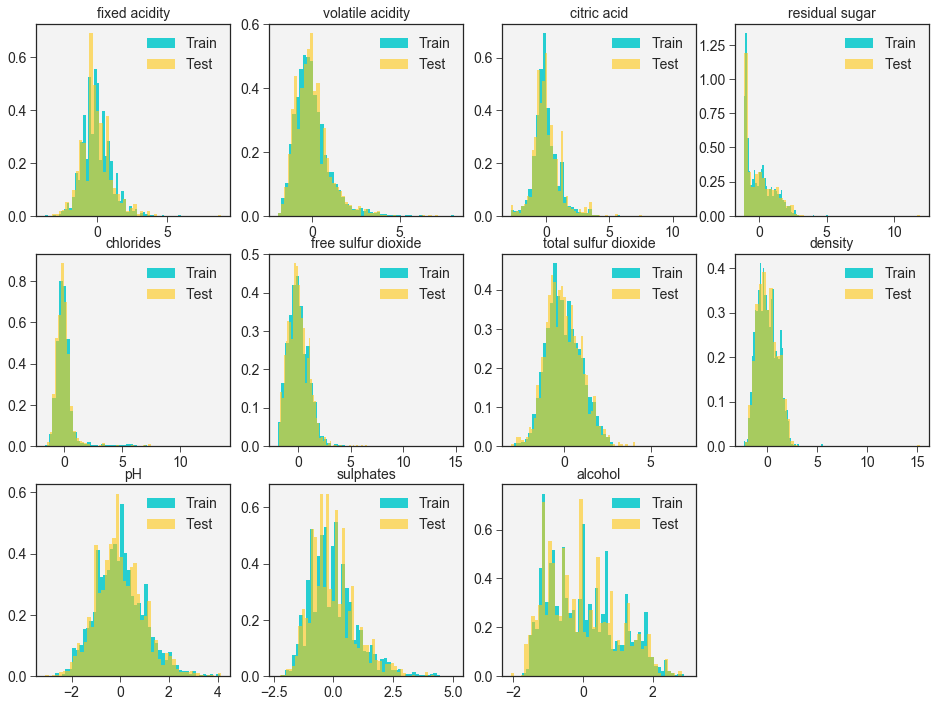

In [5]:
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.titlesize': 20})

fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3, 4, (feat_idx+1), facecolor='#f3f3f3')
    h = ax.hist(X_train_std[:, feat_idx], bins=50, normed=True, color='#25ced1', edgecolor='none', label='Train')
    h = ax.hist(X_test_std[:, feat_idx], bins=50, normed=True, color='#ffc91499', edgecolor='none', label='Test')
    ax.set_title(data.columns[feat_idx], fontsize=14)
    ax.legend(loc="upper right")

### Paramètrage du modèle
Définitions des hyperparamètres et initialisation des folds

Identique au TP, à la différence près que les folds ne sont pas générés aléatoirement (pour pouvoir mieux comparer les résultats) grâce à <code>shuffle=False</code> et <code>random_state=0</code>

In [6]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Initialisation des folds
cross_validation_folds = model_selection.StratifiedKFold(
    n_splits=5, # nombre de folds de validation croisée
    shuffle=False,
    random_state=0
)

### Aperçu des folds

Ceci est une prévisualisation simplifiée, uniquement pour information. En effet, afin que le graphique ne mette pas trop de temps à se générer, les échantillons sont groupés par 50, ce qui explique les "escaliers" de l'histogramme.

En réalité, les limites sont bien définies et les groupes ne se chevauchent pas.

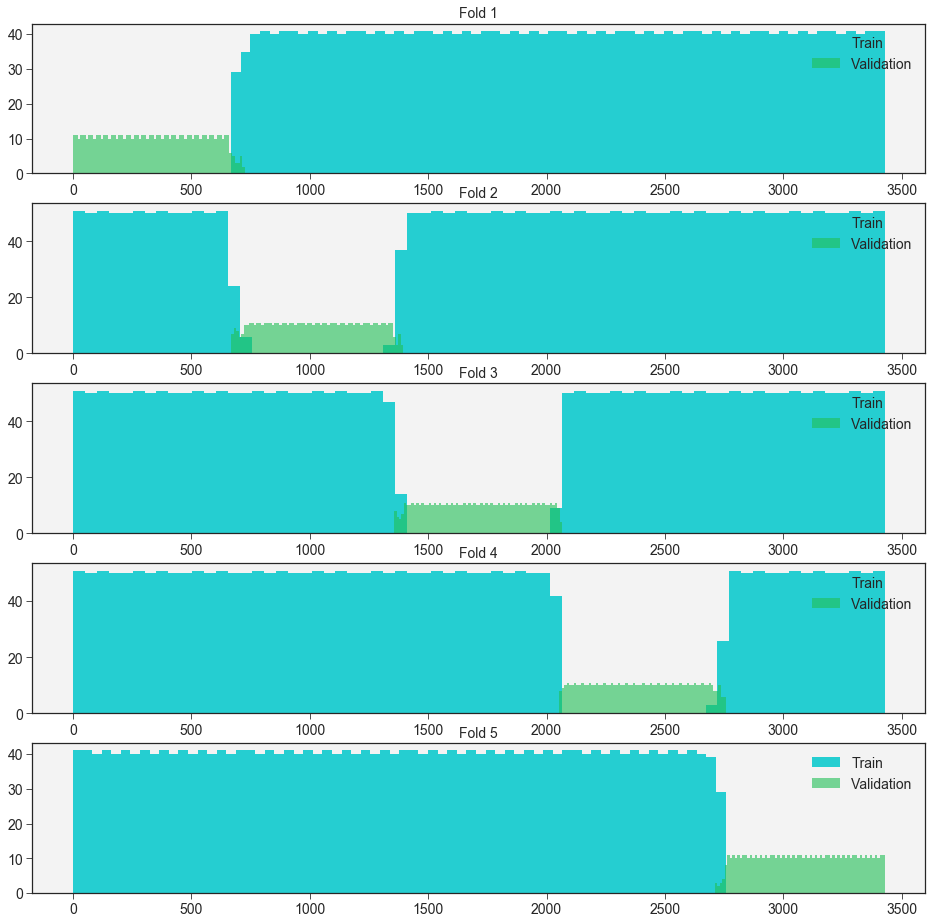

In [7]:
folds_indices = cross_validation_folds.split(X_train_std, y_train)

bins = X_train_std.shape[0] // 50
fig = plt.figure(figsize=(16, 16))
for i, indices in enumerate(folds_indices):
    train_index, test_index = indices
    ax = fig.add_subplot(5, 1, (i+1), facecolor='#f3f3f3')
    h = ax.hist(train_index, color='#25ced1', bins=bins, edgecolor='none', label='Train')
    h = ax.hist(test_index, color='#20bf5599', bins=bins, edgecolor='none', label='Validation')
    ax.set_title('Fold %d' % (i+1), fontsize=14)
    ax.legend(loc="upper right")

## Etape 2. Résultats fournis par scikit
On utilise <code>GridSearchCV</code> (comme dans le TP)

In [8]:
# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(),
    param_grid, # hyperparamètres à tester
    cv=cross_validation_folds, # validation croisée
    scoring=score # score à optimiser
    )

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (clf.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 5}


Résultats de la validation croisée

In [9]:
sklearn_results = pd.DataFrame.from_dict(
    {
        'score moyen' : clf.cv_results_['mean_test_score'],
        'écart-type du score': clf.cv_results_['std_test_score'] * 2,
        'hyperparamètres': clf.cv_results_['params']
    })

sklearn_results

,hyperparamètres,score moyen,écart-type du score
0,{'n_neighbors': 3},0.756709,0.032243
1,{'n_neighbors': 5},0.764877,0.018849
2,{'n_neighbors': 7},0.755543,0.030606
3,{'n_neighbors': 9},0.764294,0.022944
4,{'n_neighbors': 11},0.761085,0.017952
5,{'n_neighbors': 13},0.760502,0.022019
6,{'n_neighbors': 15},0.757585,0.015711


In [10]:
y_pred = clf.predict(X_test_std)
print ("\nSur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))


Sur le jeu de test : 0.750


## Etape 3. Résultats fournis par l'implémentation personnalisée

### Code de l'implémentation personnalisée

In [11]:
import itertools as it

class MyCrossValidation:
    def __init__(self, estimator, param_grid, cv, scoring):
        """Constructeur
        
        Args:
            estimator (object): classificateur à valider
            param_grid (dict): hyperparamètres à tester
            cv (object): algorithme de création des folds
            scoring (string): score à optimiser
        """
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.results = [] # les résultats sous forme de liste de dict
    
    def fit(self, X, y):
        """Lance le calcul avec les jeux de données fournis
        
        Args:
            X (array-like, sparse matrix): variables features 
            y (array-like, sparse matrix): variables cible (target)
        """
        # pour chaque combinaison d'hyperparamètres
        for hyper_parameters in self.get_hyper_parameter_combinations():
            # evaluer la performance du modèle
            self.eval_performance_for_params(X, y, hyper_parameters)
        
        # convertir les résultats au format DataFrame
        self.cv_results_ = pd.DataFrame(self.results)
        
    def get_hyper_parameter_combinations(self):
        """
        Calcule les différentes combinaisons de la grille des hyper-paramètres
        
        Par exemple {'P': [0, 1, 2]} devient [{'P': 0}, {'P': 1}, {'P': 2}]
        """
        names = sorted(self.param_grid)
        return [dict(zip(names, prod)) for prod in it.product(*(self.param_grid[name] for name in names))]
    
    def eval_performance_for_params(self, X, y, hyper_parameters):
        """
        Estime la performance du modèle suivant les hyperparamètres fournis,
        à l'aide d'une validation croisée, et stocke les résultats
        
        Args:
            X (array-like, sparse matrix): variables features 
            y (array-like, sparse matrix): variables cible (target)
            hyper_parameters (dict): hyperparamètres utilisés pour le modèle à évaluer
        """
        self.estimator.set_params(**hyper_parameters)
        accuracy_scores = list(self.eval_performance_for_each_fold(X, y))
        self.store_results(hyper_parameters, accuracy_scores)
        
    def eval_performance_for_each_fold(self, X, y):
        """
        Estime la performance du modèle à l'aide d'une validation croisée,
        pour chaque fold défini par self.cv
        
        Args:
            X (array-like, sparse matrix): variables features 
            y (array-like, sparse matrix): variables cible (target)
            
        Yields:
            float: pourcentages de fiabilité du modèle (accuracy) pour chaque fold
        """
        # pour chaque fold
        fold_indices = self.cv.split(X, y)
        for train_index, validation_index in fold_indices:
            # recuperation des sets pour le fold en cours
            X_train = X[train_index]
            X_validation = X[validation_index]
            y_train = y[train_index]
            y_validation = y[validation_index]
            
            # entrainement de l'estimateur
            self.estimator.fit(X_train, y_train)
            
            # évaluation de l'accuracy pour ce fold
            y_pred = self.estimator.predict(X_validation)
            yield metrics.accuracy_score(y_validation, y_pred)
    
    def store_results(self, hyper_parameters, accuracy_scores):
        self.results.append({
            'params': hyper_parameters,
            'mean_test_score': np.mean(accuracy_scores),
            'std_test_score': np.std(accuracy_scores),
            'accuracy': accuracy_scores
        })
    
    @property
    def best_params_(self):
        """Recupère les meilleurs hyperparamètres"""
        idx_max = self.cv_results_['mean_test_score'].idxmax()
        return self.cv_results_['params'][idx_max]
    
    def best_estimator(self, X, y):
        """Fournit un estimateur avec les meilleurs hyperparamètres,
        qui est ensuite entraîné avec les données fournies
        
        Args:
            X (array-like, sparse matrix): variables features 
            y (array-like, sparse matrix): variables cible (target)
            
        Returns:
            array: un estimateur avec les paramètres optimaux
        """
        hyper_parameters = self.best_params_
        self.estimator.set_params(**hyper_parameters)
        self.estimator.fit(X, y)
        return self.estimator
        

### Lancement de l'estimation

In [12]:
mcv = MyCrossValidation(neighbors.KNeighborsClassifier(),
    param_grid, # hyperparamètres à tester
    cv=cross_validation_folds, # validation croisée
    scoring=score # score à optimiser
    )

# Optimiser ce classifieur sur le jeu d'entraînement
mcv.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (mcv.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 5}


### Résultats de la validation croisée

In [13]:
cv_results_ = mcv.cv_results_

my_cross_validation_results = pd.DataFrame.from_dict(
    {
        'score moyen' : cv_results_['mean_test_score'],
        'écart-type du score': cv_results_['std_test_score'] * 2,
        'hyperparamètres': cv_results_['params']
    })

my_cross_validation_results

,hyperparamètres,score moyen,écart-type du score
0,{'n_neighbors': 3},0.756699,0.032245
1,{'n_neighbors': 5},0.764879,0.018848
2,{'n_neighbors': 7},0.755538,0.030602
3,{'n_neighbors': 9},0.764290,0.022939
4,{'n_neighbors': 11},0.761083,0.017948
5,{'n_neighbors': 13},0.760496,0.022018
6,{'n_neighbors': 15},0.757579,0.015713


In [14]:
y_pred = mcv.best_estimator(X_train_std, y_train).predict(X_test_std)
print ("\nSur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))


Sur le jeu de test : 0.750


## Conclusion

Voici les résultats obtenus avec scikit-learn:

In [15]:
sklearn_results

,hyperparamètres,score moyen,écart-type du score
0,{'n_neighbors': 3},0.756709,0.032243
1,{'n_neighbors': 5},0.764877,0.018849
2,{'n_neighbors': 7},0.755543,0.030606
3,{'n_neighbors': 9},0.764294,0.022944
4,{'n_neighbors': 11},0.761085,0.017952
5,{'n_neighbors': 13},0.760502,0.022019
6,{'n_neighbors': 15},0.757585,0.015711


et voici les résultats obtenus avec la validation croisée personnalisée:

In [16]:
my_cross_validation_results

,hyperparamètres,score moyen,écart-type du score
0,{'n_neighbors': 3},0.756699,0.032245
1,{'n_neighbors': 5},0.764879,0.018848
2,{'n_neighbors': 7},0.755538,0.030602
3,{'n_neighbors': 9},0.764290,0.022939
4,{'n_neighbors': 11},0.761083,0.017948
5,{'n_neighbors': 13},0.760496,0.022018
6,{'n_neighbors': 15},0.757579,0.015713


On remarque que les résultats obtenus sont très prochèes, ce qui permet de valider que l'implémentation personnalisée fonctionne bien.

In [17]:
join = my_cross_validation_results.join(sklearn_results, lsuffix=' (perso)', rsuffix=' (sklearn)')
join = join[['hyperparamètres (perso)', 'score moyen (perso)', 'score moyen (sklearn)']]
join = join.assign(difference = join['score moyen (sklearn)'] - join['score moyen (perso)'])
join

,hyperparamètres (perso),score moyen (perso),score moyen (sklearn),difference
0,{'n_neighbors': 3},0.756699,0.756709,0.000011
1,{'n_neighbors': 5},0.764879,0.764877,-0.000002
2,{'n_neighbors': 7},0.755538,0.755543,0.000005
3,{'n_neighbors': 9},0.764290,0.764294,0.000004
4,{'n_neighbors': 11},0.761083,0.761085,0.000002
5,{'n_neighbors': 13},0.760496,0.760502,0.000005
6,{'n_neighbors': 15},0.757579,0.757585,0.000005


Quelques améliorations possibles:

* Implémenter l'algorithme <code>StratifiedKFold</code> (je ne pense pas que c'était demandé dans l'exercice)
* Simplifier la méthode best_estimator